# <u> Chapter 2: Aperture photometry</u>

<div class="alert alert-block alert-info">

### This Notebook will lead you through exercises to explore signal-to-noise in imaging data.
### In this notebook, you will:

-  learn how to perform aperture photomotry and sky subtraction
    
-  learn how to choose appropriate source aperture and sky aperture sizes

-  learn how to calculate errors for your photometry

-  look into the difference between source and sky noise

-  test your aperture photometry functions on simulated datasets

### If you have time and want to take go further with your analysis:

-  test your aperture photometry functions on difficult datasets, such as crowded fields and noisy datasets

### What's next:
after you have completed this notebook:

-  finalize your own aperture photometry function to use for Coursework B


### Table of contents:

- [Background: Photometry in Astronomy](#sec:bg)
    
- [1. Aperture photometry - step by step](#sec:stepbystep)

- [1.1 Defining the aperture](#sec:aperture)

- [1.2 Measuring fluxes](#sec:flux)
    
- [1.3 Estimating sky levels](#sec:sky)

- [2. Practice](#sec:practice)

    - [Advanced practice: noisy images](#sec:practice-noise)
    - [Advanced practice: crowded fields](#sec:practice-crowded)
- [Summary](#sec:summary)

[The aperture photometry function required for Coursework A](#aperturefunction)
</div>

In [1]:
### Necessary imports fore this notebooks.
# ImageSimulator is a supplemtary set of code used to simulate the test images used 
import ImageSimulator
#Photutils is the model we will use for aperture photometry.
#The documentation is available here: https://photutils.readthedocs.io/en/stable/index.html
from photutils import aperture_photometry
import photutils
import numpy as np

<a id="sec:bg"></a>
## Background - Photometry in Astronomy

For your research project, you will be working with photometry data. This refers to measuring the flux or magnitude of a source in an image. In your project, you will be working with point sources (that means sources that are unresolved at the resolution of the image).

#### Photometry in astronomy is used to:

$\bullet$ measure the flux of a source in a specific band, which can be used to determine the luminosity of a source

$\bullet$ contruct a so-called spectral energy distribution that measures the flux from a source as a function of wavelength or frequency. This can be used to determine intrinsic phyiscal properties of a source, such as its temperature, chemical composition, or in case of a galaxy, the stellar population.

$\bullet$ measure how an object's light evolves with time (often called a lightcurve), which can be used to study transient events such as supernovea, stochastic processes such as accretion onto black holes as well as dynamical systems such as binary stars and exoplanets. The latter example is what you will be working on in your research project. 

#### Signal in astronomical images:

Photometry is measured on images of the sky. Emission detected in such an image may come from:

$\bullet$ the source itself

$\bullet$ other sources in the field

$\bullet$ sky emission, generally uniform across the field

$\bullet$ scatter emission originating from within the instrument

$\bullet$ the bias: a signal added in charged coupled device (CCD) devices to avoid negative counts

#### The signal is affected by:

$\bullet$ differences in transmission through the atmosphere, i.e., only a fraction of flux will arrive on the ground. This is dealt with by measuring the flux relative to a star in the field with known magnitude/flux. You will work on this in the DataReduction section. In your research case, you will be using space-based photometry.

$\bullet$ differences in transmission through the instrument that vary across the field. This is corrected for using so-called flat-fields. Flat fields are images taken of the sky at dawn, these are used to correct for the differences in transmission. You will see an example of this un the DataReduction section. 

#### Spatial resolution in astronomical imaging:

Another important effect is that the image is effectively convoluted by the so-called point-spread function. This means that all point sources are detected as extended sources, here, we treat them as two-d gaussians:

$ PSF(x, y) = \frac{1}{\sigma^2 \sqrt{2\pi}} exp\left[ \frac{(x-x_0)^2 + (y-y_0)^2}{2\sigma^2}\right] $

where $x_0,y_0$ is the position and $\sigma$ the standard devition. In astronomy, rather than the standard deviation, we often use the so-called full-width at half maximum which is:

$ FWHM = 2 \sqrt{ln 2}\sigma \approx 2.35\sigma$.

#### A side note on units:

Astronomical images can have a range of different units, these can be counts/s. These are related through the gain, which turns counts or electrons per second into photons per second. However, when calculating errors, we are calculating Poisson noise, which is a counting noise error. This error needs to be calculated using the integrated number of photons in the exposure. In this notebook, we will be working with images in units of photons. 

#### Photometry and errors:

To perform aperture photometry, we therefore need to isolate the source emission from other signal and correct for losses in transmission (the latter will be covered in the Data Reduction section).

Additionally, we will need to calculate the error in our measurement. The main source of noise in astronomical data is Poisson or shot noise. The uncertainty $\sigma$ in measuring $N$ photons  is:

$ \sigma = \sqrt{N}$

The number of expected photons scales linearly with time, i.e., by doubling the exposure time, we expected to recieve twice as many photons. Note here that the noise $\sigma$ \textit{increases} with N, however, the property we are interested in is the signal to noise SN, i.e.:

$SN = \frac{N}{\sigma} = \sqrt{N}$

Therefore, since the expected number of photons N $\propto$ exposure time t, the SN increases with the exposure time as \sqrt{t}.

Additionally, due to the fact that the CCD readout adds noise in each pixel, each pixel has an added noise called the read-out noise (RON). This is generally well known for each instrument.

We will need to combine these errors later on, remember these equations for combining errors:

$A = B + C ,\ \sigma_A = \sqrt{\sigma_B^2 + \sigma_C^2}$

$A = B * C \ or A = \frac{B}{C} ,\  \frac{\sigma_A}{A} = \sqrt{\left(\frac{\sigma_B}{B}\right)^2 + \left(\frac{\sigma_C}{C}\right)^2}$

#### There are two general approaches to phomometry:

$\bullet$ Aperture photometry: is very commonly used in astronomy. It in involves integrating the flux from the sources within a (generally circular) aperture. This is the method we will be using here. We will need to consider the size and placement of the aperture and subtraction of background.

$\bullet$ PSF photometry: this involved fitting a model of the PSF to sources. It can be more accurate than aperture photometry, especially in extremely crowded fields where sources overlap. PSF photometry requires a detailed modelling of the PSF across the field. 

This is the summary of background information needed to complete this tutorial.

<a id="sec:stepbystep"></a>
## 1. Aperture photometry - step by step
Below, you see a simulated image. The colour bar on the right indicates the counts per pixel. Can you locate the source?

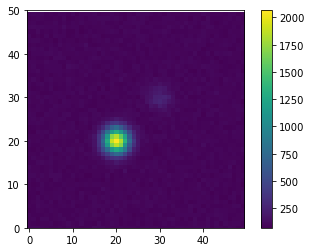

In [2]:
#The line below creates the tutorial image.
myIma = ImageSimulator.tutorial_image()
#You can plot the image like this
myIma.show_ima()

In [3]:
myIma.get_data()

array([[ 97, 103, 109, ...,  96,  80, 101],
       [102,  93,  85, ..., 109, 106,  91],
       [102, 104,  85, ...,  97, 102, 108],
       ...,
       [102, 105,  88, ...,  98,  97, 101],
       [ 93, 100, 105, ...,  89, 103,  90],
       [106, 112, 104, ..., 108,  82,  95]])

In [4]:
myIma._y

array([[ 0,  0,  0, ...,  0,  0,  0],
       [ 1,  1,  1, ...,  1,  1,  1],
       [ 2,  2,  2, ...,  2,  2,  2],
       ...,
       [47, 47, 47, ..., 47, 47, 47],
       [48, 48, 48, ..., 48, 48, 48],
       [49, 49, 49, ..., 49, 49, 49]])

In [5]:
#If you ever need, the data in the image can be accessed like this
test_data = myIma.get_data()
print(test_data)
#This is a numpy array.


[[ 97 103 109 ...  96  80 101]
 [102  93  85 ... 109 106  91]
 [102 104  85 ...  97 102 108]
 ...
 [102 105  88 ...  98  97 101]
 [ 93 100 105 ...  89 103  90]
 [106 112 104 ... 108  82  95]]


You can also plot slices through the image in either x or y as folllows.


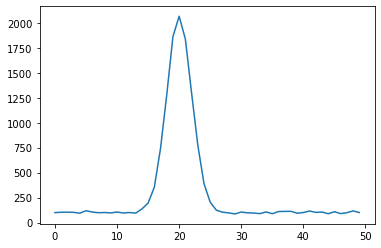

In [6]:
myIma.plot_x(20)

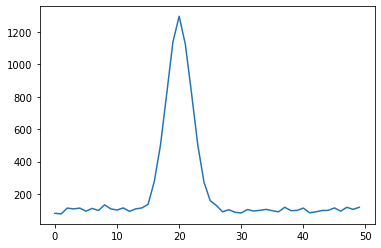

In [7]:
myIma.plot_y(22)

<div class="alert alert-block alert-success">

### Your turn: Explore the image

Use the slice tool above to explore the image. Where is the source located? What else can you learn using the slice tool?
</div>

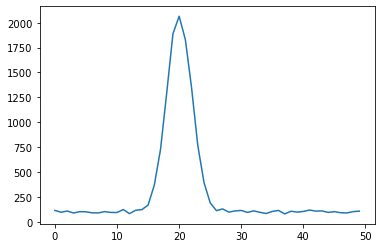

In [8]:
myIma.plot_y(20)

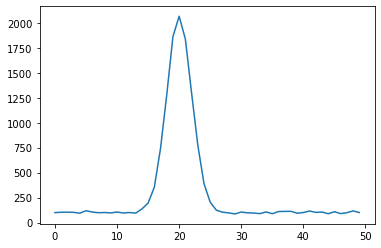

In [9]:
myIma.plot_x(20)

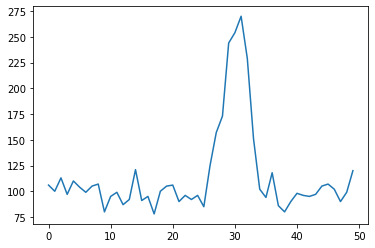

In [10]:
myIma.plot_y(30)

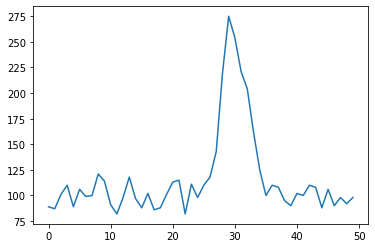

In [11]:
myIma.plot_x(30)

<a id="sec:aperture"></a>
## 1.1 Aperture Photometry - Defining the aperture


Having identified the source visually and using the slice tool, we can now define a circular aperture, this is basically a circular mask that defines the area over which we will sum the flux from the source. We will use photutils.CircularAparture as follows:

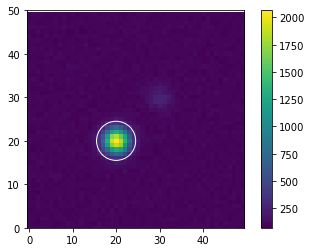

In [12]:
#Defining an aperture:
xpos = 20 #guess for x position
ypos = 20 #guess for y position
rad = 4.5 #aperture radius
aperture1 = photutils.CircularAperture((xpos, ypos), rad)
#Show the initial image again and overplot the aperture
myIma.show_ima()
aperture1.plot(ec='white')

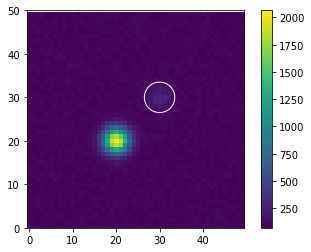

In [13]:
#Defining an aperture:
xpos2 = 30 #guess for x position
ypos2 = 30 #guess for y position
rad2 = 3.5 #aperture radius
aperture2 = photutils.CircularAperture((xpos2, ypos2), rad2)
#Show the initial image again and overplot the aperture
myIma.show_ima()
aperture2.plot(ec='white')

Try redefining the aperture to match the position.

<a id="sec:flux"></a>
## 1.2 Aperture Photometry - Measuring fluxes

Having defined the aperture, we can now perform the aperture photometry, the code below shows how we can calculate the flux in the aperture.

In [14]:
#The code below shows how we use the function aperture photometry to apply aperture1 to the image myIma._realima
phot = aperture_photometry(myIma.get_data(), aperture1)
#the result is stored in phot, let's have a look
print(phot)


 id xcenter ycenter   aperture_sum  
      pix     pix                   
--- ------- ------- ----------------
  1    20.0    20.0 51961.1418035125


You can access the results as a dictionary, e.g.:

In [15]:
phot['aperture_sum']

51961.1418035125


In [16]:
#We can access the area covered by the aperture as follows
aperture1.area

63.61725123519331

In [17]:
#The code below shows how we use the function aperture photometry to apply aperture1 to the image myIma._realima
phot2 = aperture_photometry(myIma.get_data(), aperture2)
#the result is stored in phot, let's have a look
print(phot2)


 id xcenter ycenter    aperture_sum  
      pix     pix                    
--- ------- ------- -----------------
  1    30.0    30.0 6975.403312159667


In [18]:
phot2['aperture_sum']

6975.403312159667


In [19]:
aperture2.area

38.48451000647496



<div class="alert alert-block alert-success">

### Your turn: Explore the image further. Do you notice anything unusual?
</div>

another faint spot in backrgound at 30,30

<div class="alert alert-block alert-success">

### Your turn: Consider how to best choose the size of the aperture

Try varying the aperture radius and replotting. You can also use the slice plotting you learned above to guide your choioce. What do you think is a good choice for aperture?
    
</div>

~4.5/5 aperture size

<a id="sec:sky"></a>
## 1.3 Aperture Photometry - Estimating sky levels

The main contamination to the signal will be sky emission. You might have noticed this already. We can estimate sky levels either by creating an annulus around the object or by estimating the sky in different areas of the image. Below, we show how you can use both using the code provided.

 id xcenter ycenter    aperture_sum   
      pix     pix                     
--- ------- ------- ------------------
  1    20.0    20.0 33380.351962410874
Sky area is :263.89378290154264


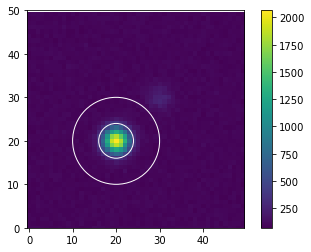

In [20]:
# defining a sky annulus at position 20, 20 with inner radius 4, outer radius 10
ringsky = photutils.CircularAnnulus((20, 20), 4, 10)
# 
sky_annulus = aperture_photometry(myIma.get_data(), ringsky)
print(sky_annulus)
print('Sky area is :' + str(ringsky.area))
myIma.show_ima()
ringsky.plot(ec='white')

 id xcenter ycenter    aperture_sum   
      pix     pix                     
--- ------- ------- ------------------
  1    20.0    20.0 32238.051503489725
Sky area is :282.7433388230814


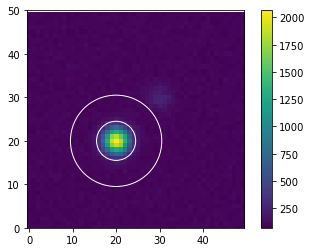

In [21]:
ringsky = photutils.CircularAnnulus((20, 20), 4.5
                                    , 10.5)
# 
sky_annulus = aperture_photometry(myIma.get_data(), ringsky)
print(sky_annulus)
print('Sky area is :' + str(ringsky.area))
myIma.show_ima()
ringsky.plot(ec='white')

<div class="alert alert-block alert-success">

### Your turn: Consider different sizes for the sky ring. What is the optimal choice?
</div>

just before interferes with other light source

## Aperture photometry - different ways to measure sky

Above, we have measured the sky using a ring around the source. We could also measure the sky in a circle. 

 id xcenter ycenter    aperture_sum  
      pix     pix                    
--- ------- ------- -----------------
  1    30.0    27.0 7376.463774323748
Sky area is :50.26548245743669


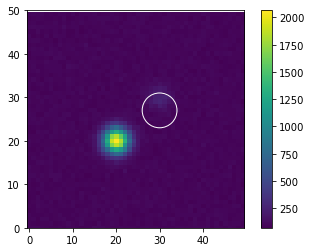

In [22]:
#Defining a sky area 
awaysky = photutils.CircularAperture((30, 27), 4)
#
sky_circle = aperture_photometry(myIma._realima, awaysky)
print(sky_circle)
print('Sky area is :' + str(awaysky.area))
myIma.show_ima()
awaysky.plot(ec='white')

<div class="alert alert-block alert-success">

### Your turn: Try different sky positions and comment on how the sky should be placed.
</div>

 id xcenter ycenter    aperture_sum  
      pix     pix                    
--- ------- ------- -----------------
  1    12.0    38.0 31473.40701441125
Sky area is :314.1592653589793


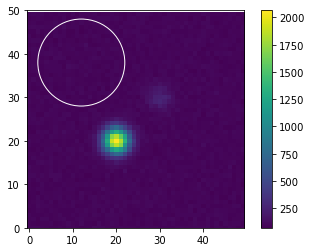

In [23]:
#Defining a sky area 
awaysky = photutils.CircularAperture((12, 38),10 )
#
sky_circle = aperture_photometry(myIma._realima, awaysky)
print(sky_circle)
print('Sky area is :' + str(awaysky.area))
myIma.show_ima()
awaysky.plot(ec='white')

<div class="alert alert-block alert-success">

### Your turn: Compare the two methods to measure sky levels.
</div>

In [24]:
#sky level 1 ring
sky_annulus['aperture_sum']/ringsky.area

114.01878338736662


In [25]:
#sky level 2 circle
sky_circle['aperture_sum']/awaysky.area

100.18296604573364


less flux with away circle sky than with ring
nmore significant if smaller circle away from source

<div class="alert alert-block alert-success">

### Your turn: Aperture Photometry - Write a function to calculate the flux of a star given the results of the measurements made.

You have now measured the flux in the aperture and sky aperture. Write a function to caculate the object flux.

<a id="aperturefunction"></a>
### The aperture photometry function
The call below contains the basis to the aperture photometry. Fill in the gaps to write your own function to use for Coursework A.

In [1]:

def ap_phot(image, x, y, radius, skyx, skyy, skyinner, skyouter,ron):
    #Defining the object aperture
    ap = photutils.CircularAperture((x, y), radius)
    #measuring the flux in the object aperture
    fl_ap = aperture_photometry(image, ap)
    #Defining the sky perture, if syinner=0, create a circular ap, otherwise, create an annulus
    if skyinner == 0:
        ap_sky = photutils.CircularAperture((skyx, skyy), skyouter)
    else:
        ap_sky = photutils.CircularAnnulus((skyx, skyy), skyinner, skyouter)
    #measure the flux in the sky
    fl_sky = aperture_photometry(image, ap_sky)
    #the areas of each of the apertures are
    obj_area = ap.area
    sky_area = ap_sky.area
    
    #Write down the flux in the oject given
    #fl_ap: the flux in the aperture
    #fl_sky: the flux in the sky aperture
    #obj_area: area of object aperture
    #sky_area: area of sky aperture
    
    fl_object = (fl_ap['aperture_sum'][0])-((fl_sky['aperture_sum'][0]/sky_area)*obj_area) #scale to same area
    
    #Similarly, also calculate the error:
    
    #the shot noise in the main aperture:
    shot_ap = np.sqrt(fl_ap['aperture_sum'][0])
    #uncertainty in the sky level
    std_sky = np.sqrt(fl_sky['aperture_sum'][0]/sky_area)
    unc_sky = std_sky/np.sqrt(sky_area)
    ## add your equation for the uncertainty in the sky  here ste of mean sigma/rootN*pixels in ap
    ron =  ron ## add your equation for the readout noise here multiply RON*pixel number
    
    #add the other sources of error
    err_obj = np.sqrt((shot_ap)**2 + (unc_sky)**2*obj_area + (ron**2)*obj_area)
    
    return fl_object, err_obj

<div class="alert alert-block alert-success">

### Your turn: Aperture Photometry - Write a function to calculate the error 

Using the equations given above, write a function to calculate the error in your flux.
</div>

In [22]:
print(ap_phot(test_me._realima,26,26,15,8,8,0,8,1.21))

(1107199.8224980056, 1091.8938196254337)


In [2]:
test_me.plot_y(23)

NameError: name 'test_me' is not defined

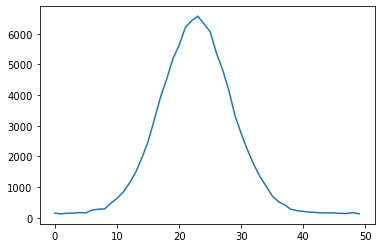

In [25]:
test_me.plot_x(28)

In [ ]:
ring = photutils.CircularAperture((28, 23), 20)
test_me.show_ima()
ring.plot(ec='white')

## <a id="sec:practice"></a>
## 2. Aperture photometry: Practice
Below, you can find instructions how to create random images that you can use to test your aperture photometry functions. We will start with a high-SN image with a single star in the field. You can create a random image as follows.

This class will simulate a single PSF in the centre of the field with high SN. RON is 1.21


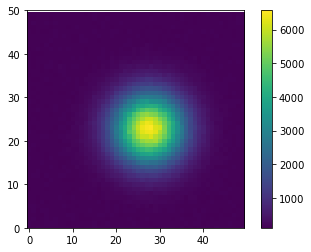

In [4]:
test_me = ImageSimulator.centred_psf_highSN()

Everytime you rerun the cell above, a different test image is created. You can access the data and show the image as you did before in the tutorial image. This time, you can give a guess for the source position and flux, and the function will then tell you if your estimate is correct. You can plot the x and y slices as was done before.

Here, I am guessing that the source is in the middle of the image, that the source flux is 700, the measurement error in the flux is 50 and the position error is 2.

In [23]:
test_me.guess_psf(x=28,y=23,flux=1107199.8224980056, error=1091.8938196254337, poserr=1)

your guess: x,y = 27.50, 26.00 (+- 1.00), flux=1107199.82 +- 1091.89
Matched in X position
No match found.


If you are lost, you can get the description of your random image as follows:

In [36]:
test_me.explain_practiceima()

There are 1 Objects in this image
They have the following parameters:
x, y, flux
-----------
26.77, 27.32, 4594969.52
-----------
Background level: 255.17
Radius/FWHM: 5.30/12.44
RON: 3.32 added
Shot noise added


<a id="sec:practice-noise"></a>
## Aperture Photometry - Advanced practice - noisy Images

If you have gotten a good hold of the practice set above, you can try these advanced examples. The first one gives a noisier version of the one above. The guesses and solutions work as above.

This class will simulate a single PSF in the centre of the field with low SN. RON is 1.10


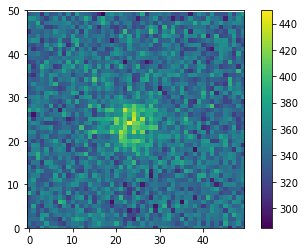

In [59]:
test_lowSN = ImageSimulator.centred_psf_lowSN()

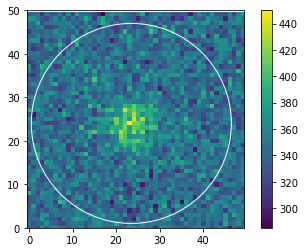

In [81]:
ring = photutils.CircularAperture((23.5, 24), 23)
test_lowSN.show_ima()
ring.plot(ec='white')

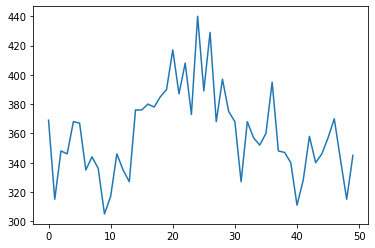

In [68]:
test_lowSN.plot_y(25
                 )

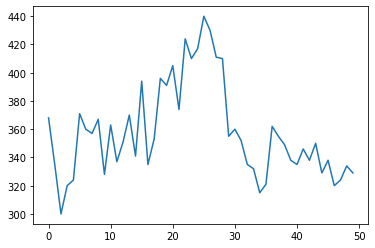

In [72]:
test_lowSN.plot_x(24)

In [82]:
print(ap_phot(test_lowSN._realima,23.5,24,8,23.5,24,10,23))

(5483.314709505183, 274.5580718449257)


In [78]:
test_lowSN.guess_psf(x=23.5,y=24,flux=5297.390152507418, error=275.09561266646944, poserr=1)

your guess: x,y = 23.50, 24.00 (+- 1.00), flux=5297.39 +- 275.10
Matched in X position
Matched in Y position
Match in position, but not flux.
No match found.


In [79]:
test_lowSN.explain_practiceima()

There are 1 Objects in this image
They have the following parameters:
x, y, flux
-----------
23.13, 23.68, 6779.17
-----------
Background level: 345.28
Radius/FWHM: 3.89/9.15
RON: 1.10 added
Shot noise added


<a id="sec:practice-crowded"></a>
## Aperture Photometry - Advanced practice - Crowded Fields

The next example is more challenging, this is a good chance to make use of plotting to identify where the sources are.

A crowded field with several psfs. RON is 2.96


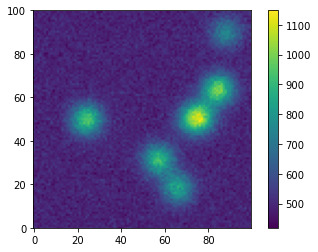

In [162]:
test_crowded = ImageSimulator.crowded_field()

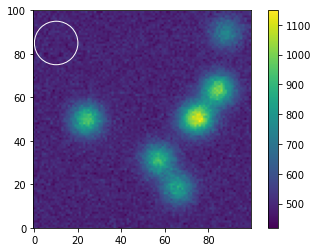

In [256]:
ring = photutils.CircularAperture((10, 85), 10)
test_crowded.show_ima()
ring.plot(ec='white')

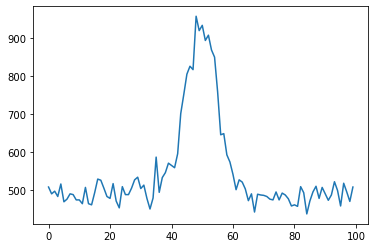

In [242]:
test_crowded.plot_x(23)

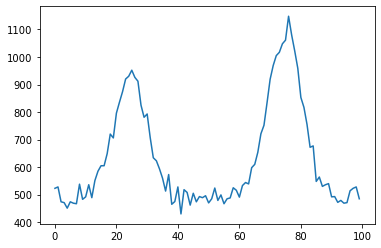

In [249]:
test_crowded.plot_y(49)

In [266]:
print(ap_phot(test_crowded._realima,23.5,49,15,10,85,0,8))

(71034.29605272174, 457797.7044648234)


In [264]:
test_crowded.guess_psf(x=23.5,y=49,flux=71034.29605272174, error=3000.8828825895345, poserr=1)

your guess: x,y = 23.50, 49.00 (+- 1.00), flux=71034.30 +- 3000.88
Matched in X position
Matched in Y position
Matching psf with x = 24.19, y = 49.73, flux = 72302.68
Well done!


If you get stuck, you can show the number of objects in the field as follows:

In [267]:
test_crowded.show_objectnumber()

There are 7 PSFs in this field. Good hunting!


You can also reveal the positions.

In [268]:
test_crowded.show_positions()

There are 7 Objects in this image with positions
x, y
-----------
57.20, 31.36
24.19, 49.73
87.98, 89.60
65.89, 18.25
72.44, 49.51
84.52, 63.49
76.09, 50.99


<div class="alert alert-block alert-info">

<a id="sec:summary"></a>
## Summary & Coursework Notes

After completing this notebook, you should have:

- applied aperture photometry and error estimation techniques
- written your own photometry function

In <b>Coursework A</b>, you will be assessed on your understanding of these techniques, you will need to apply your photometry funtion to simulated data. You will also need to answer questions on decisions made when choosing aperture photometry paraneters.
</div>